# Deep Q-Network

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax.random as jrandom

from src.NeuralNetwork.ANN import NeuralNet
from src.RL.DQLearning import DQLearning
from src.systems.linear import StochasticDoubleIntegrator
from src.controllers.utilities import *

## Neural Network
First, I create a simple neural network to make predictions based on an input. I shortly test of the NN can indeed learn a noisy linear function

In [5]:
key = jrandom.PRNGKey(0)
architecture = (1, 1)
activation = ['linear']

NN = NeuralNet(key, architecture, activation)

In [13]:
n_input = 1
n_samples = 500

def f(x):
    return 2*x

x_train = jrandom.normal(key, (n_samples, n_input))
x_test = jnp.linspace(-1, 1, 20)
y_train = f(x_train) + jrandom.normal(key, (n_samples, n_input))
y_test_true = f(x_test)

NN.train_batch(x_train, y_train)
y_test_prediction = NN.predict_batch(x_test)


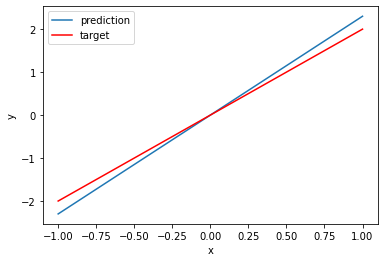

In [14]:
fig, ax = plt.subplots()
ax.plot(x_test, y_test_prediction, label='prediction')
ax.plot(x_test, y_test_true, color='r', label='target')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()

## Initiate the Q-learning problem

Secondly, the network above is combined with a Q-learning agent. Instead of function f(x), the network output is now trained using the q-learning update rule.
\begin{equation}
    Q(s) = (1 - \alpha) Q(s) + \alpha \left[ R_s + \gamma \max_{u} Q(s'\rvert s, u) \right]
\end{equation}
Hence, the network output represents the Q-values. In other words, the NN above replaces the Q-table in the regular Q-Learning.

(2000,)


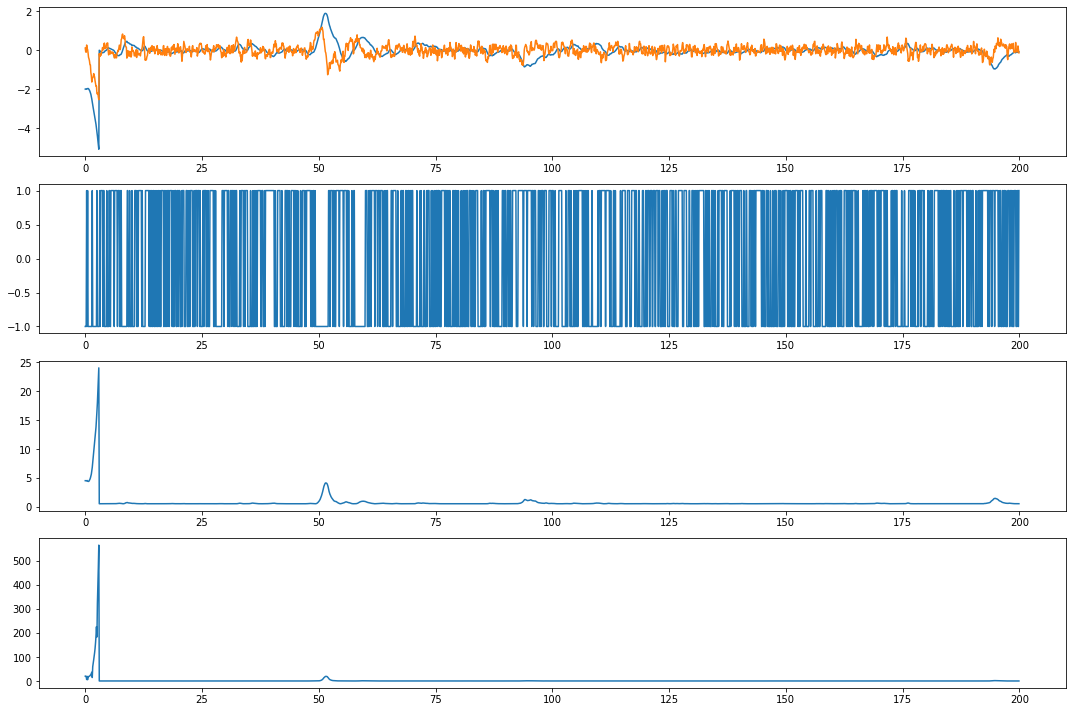

In [14]:
key = jrandom.PRNGKey(1)

# Initialize system
x0 = np.array([-2, 0])
SDI = StochasticDoubleIntegrator(x0)

# Initialize neural network
architecture = (2, 2)
activation = ['linear']
NN = NeuralNet(key, architecture, activation, eta=1e-4)

# Choose controler
DQL = DQLearning(NN, SDI.dim)

# Train controler
th, X, U, C, L, DQL = run_controlled_environment(key, DQL, SDI, 200, learning=True, training_wheels=True)
print(U.shape)

fig, ax = plt.subplots(4, figsize=(15,10))
ax[0].plot(th, X[:, 0])
ax[0].plot(th, X[:, -1])
ax[1].plot(th, U)
ax[2].plot(th, C)
ax[3].plot(th, L)
plt.tight_layout()



Notice that guaranteeing converegence requires restricting the state space at the beginning of the learning process.
1. Because the cost function is quadratic, the gradient will explode for larger states $s$.
2. We are especially interested in the dynamics around $s_0 = 0$. So we should help the controller to explore the dynamics around this state.

To guarantee effective learning, I have implented 'training wheels'. That is, the position is bound by $x \in [-5, 5]$. Another way to guarantee convergence is to let the learning rate adapt to the cost/position, to compensate for the quadratic cost.

### Test

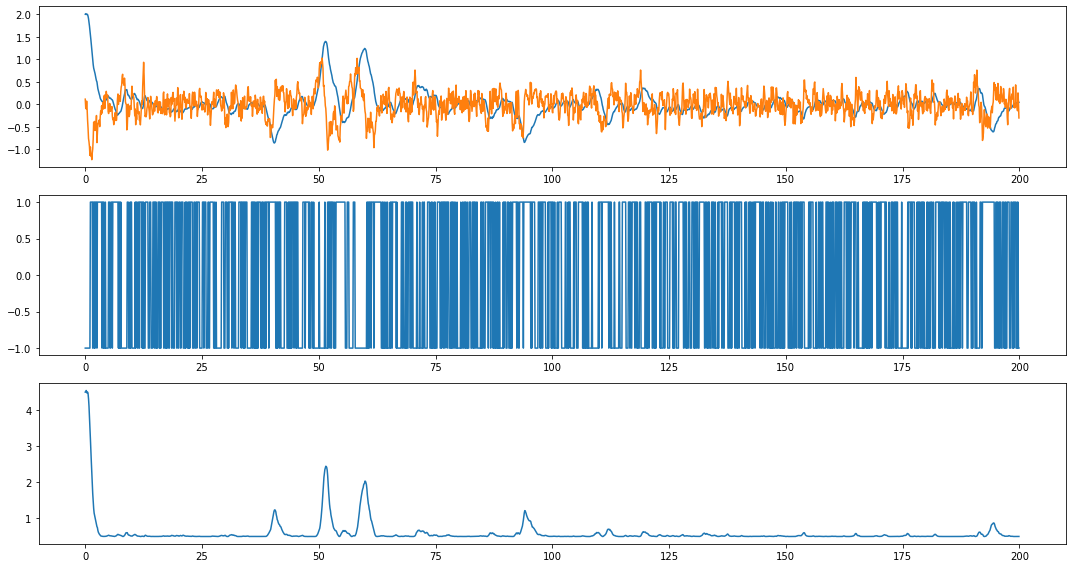

In [15]:
# Initialize system
x0 = np.array([2, 0])
SDI = StochasticDoubleIntegrator(x0)

# Run controler
th, X, U, C, _, DQL = run_controlled_environment(key, DQL, SDI, 200, learning=False)

fig, ax = plt.subplots(3, figsize=(15,8))
ax[0].plot(th, X[:, 0])
ax[0].plot(th, X[:, -1])
ax[1].plot(th, U)
ax[2].plot(th, C)
plt.tight_layout()

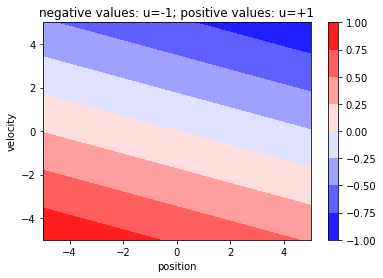

In [17]:
from matplotlib import cm

n=10
x = np.linspace(-5,5,n)
y = np.linspace(-5,5,n)
xv, yv = np.meshgrid(x,y)
z = np.zeros((2, n, n))
for i in range(n):
    for j in range(n):
        qvals = DQL.get_qval(jnp.array([xv[i,j], yv[i,j]]))
        z[0,i,j] = qvals[0]
        z[1,i,j] = qvals[1]

plt.contourf(xv, yv, z[1] - z[0], cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('negative values: u=-1; positive values: u=+1');

### Non-binary control spaces

(2000,)


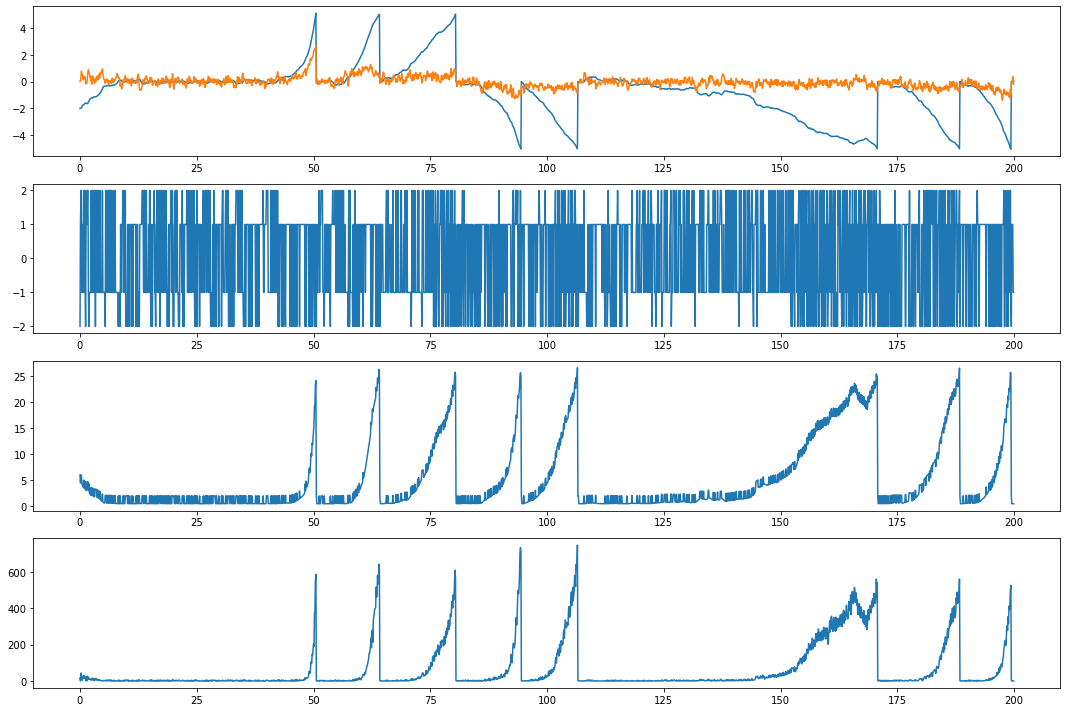

In [11]:
key = jrandom.PRNGKey(1)

# Initialize system
x0 = np.array([-2, 0])
ctrl_space = jnp.array([-2, -1, 1, 2])
SDI = StochasticDoubleIntegrator(x0)

# Initialize neural network
architecture = (2, 4)
activation = ['linear']
NN = NeuralNet(key, architecture, activation, eta=1e-4)

# Choose controler
DQL = DQLearning(NN, SDI.dim, ctrl=ctrl_space)

# Train controler
th, X, U, C, L, DQL = run_controlled_environment(key, DQL, SDI, 200, learning=True, training_wheels=True)
print(U.shape)

fig, ax = plt.subplots(4, figsize=(15,10))
ax[0].plot(th, X[:, 0])
ax[0].plot(th, X[:, -1])
ax[1].plot(th, U)
ax[2].plot(th, C)
ax[3].plot(th, L)
plt.tight_layout()

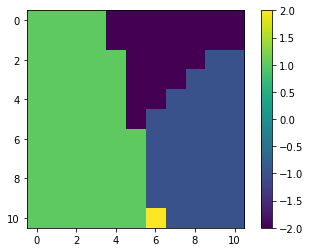

In [12]:
Z = np.zeros((11, 11))
x0_space = np.linspace(-5, 5, 11)
x1_space = np.linspace(-5, 5, 11)

for i, x0 in enumerate(x0_space):
    for j, x1 in enumerate(x1_space):
        qvals = DQL.get_qval(jnp.array([x0, x1]))
        Z[i, j] = ctrl_space[np.argmax(qvals)]

fig, ax = plt.subplots()
cbar = ax.imshow(Z)
plt.colorbar(cbar)